In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18
import h5py as h5
import corner
from latex import *

Read simulation data.

In [3]:
data_raw = np.loadtxt("./data/mergers__logMneg2tukey3.7to7.3_rhlinear0.3to3pc.txt", unpack=True)

In [4]:
labels=['channel', 'a','e', 'm1','m2','chi1','chi2','g1','g2',
        'tform','tmerge','zform','zmerge','Nhar','Nsub','q',
        'chieff', 'theta1', 'theta2', 'dphi','mrem', 'chirem', 'gren', 'vgw', 'j1', 'j2', 'Mcl_0', 'zcl_form', 'rh', 'Z']
data_raw = np.core.records.fromarrays(data_raw, names=labels, formats=['f8']*len(labels))

In [5]:
data = data_raw[(data_raw['g1']<4)*(data_raw['zmerge']>0)]

In [6]:
weight = Planck18.lookback_time_integrand(data['zcl_form'])/Planck18.lookback_time_integrand(data['zmerge']) \
    *Planck18.differential_comoving_volume(data['zmerge']).value/(1+data['zmerge'])
weight *= 3.645/(data['rh']-0.3)#np.ones(data.size)#
weight[(data["rh"]<0.5)+(data["rh"]>3)+(data["Mcl_0"]<10**4)+(data["Mcl_0"]>10**7)] = 0

Compare mass distribution in different cluster mass bins.

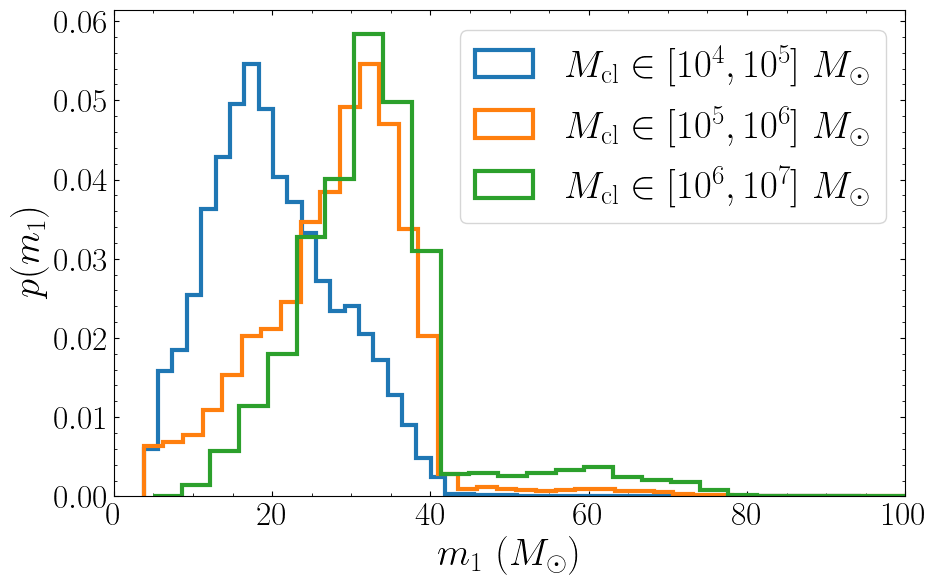

In [7]:
plt.xlabel(r"$m_1~(M_{\odot})$")
plt.ylabel(r"$p(m_1)$")
for (lower, upper) in zip([4, 5, 6], [5, 6, 7]):
    selected_range = (data['Mcl_0']<10**upper)*(data['Mcl_0']>=10**lower)
    plt.hist(data['m1'][selected_range], bins=50, histtype="step", density=True, label=r"$M_{\mathrm{cl}} \in [10^{%d}, 10^{%d}]~M_{\odot}$" %(lower, upper), lw=3, weights=weight[selected_range])
plt.tick_params(direction="in", which="both", top=True, right=True)
plt.legend()
plt.xlim(0, 100)
plt.savefig("./plots/p_m1_comparison.pdf")

Paper plot for the BH mass-cluster mass correlation.

In [8]:
def HPD_interval(data,mass=0.9):
    Data=np.sort(data)
    nsamp=Data.shape[0]
    length=int(mass*nsamp)
    starts=Data[:nsamp-length+1]
    ends=Data[length-1:]
    intervals=ends-starts
    min_idx=np.argmin(intervals)
    return starts[min_idx], np.median(Data), ends[min_idx]

def get_stats_1d(samples, weights, size=1000):
    samples_re = np.random.choice(samples, p=weights, size = size, replace=True)
    lower, median, upper = HPD_interval(samples_re)
    return lower, median, upper

In [9]:
log10Mcllabel = r"$\log_{10}(M_{\mathrm{cl}}/M_{\odot})$"
m1label = r"$m_1~(M_{\odot})$"
rhlabel = r"$r_h~(\mathrm{pc})$"

/tmp/ipykernel_2447/2980766702.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


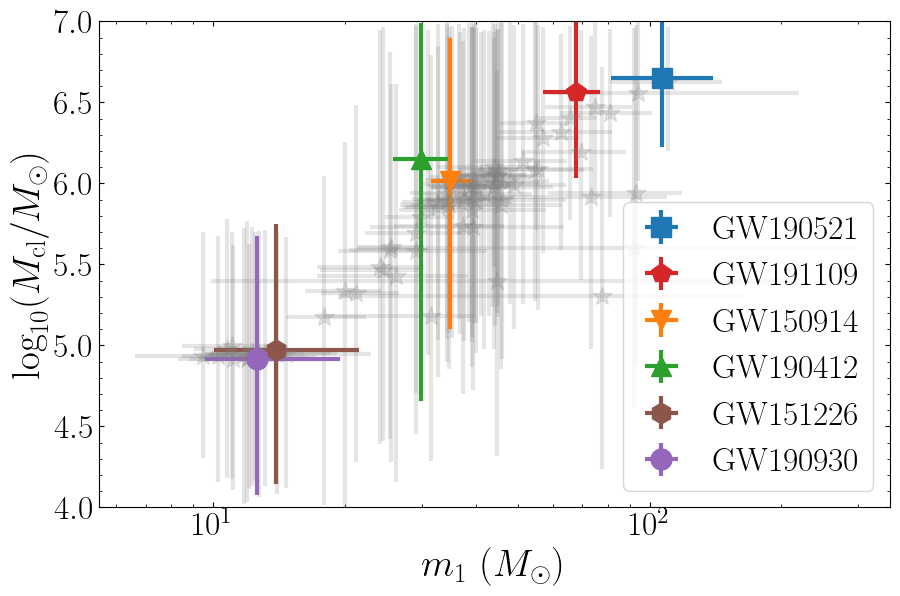

In [12]:
selected_names = {\
    "GW190521_030229": (r"GW190521", "C0", "s"),\
    "GW191109_010717": (r"GW191109", "C3", "p"),\
    "GW150914_095045": (r"GW150914", "C1", "v"),\
    "GW190412_053044": (r"GW190412", "C2", "^"),\
    "GW151226_033853": (r"GW151226", "C5", "h"),\
    "GW190930_133541": (r"GW190930", "C4", "o")}
event_names_raw = np.loadtxt("./GWTC3-posteriors/event_names_BBH.txt", dtype="str")
event_names = []
for name in event_names_raw:
    if name not in selected_names:
        event_names.append(name)
event_names += list(selected_names.keys())
fig, ax = plt.subplots(1,1)
for (i, name) in enumerate(event_names):
    try:
        #name = event[16:31]
        cat = h5.File("./Mcl_rh_posterior/"+name+".h5", 'r')
        logMcl_rh_weights = cat["logMcl_rh_weights"][()]
        PEprior_weights = cat["PEprior_weights"][()]
        efficiency_weights = cat["efficiency_weights"][()]
        points = cat["points"][()]
        total_weights = logMcl_rh_weights*PEprior_weights*efficiency_weights
        total_weights /= np.sum(total_weights)
        logMcl_samples, rh_samples = points["logMcl"], points["rh"]
        logMcl_pos_samples = np.random.choice(logMcl_samples, p=total_weights, size = 1000, replace=True)
        logMcl_pos_lower, logMcl_pos_median, logMcl_pos_upper = HPD_interval(logMcl_pos_samples)
        cbc_pos_samples_raw = np.maximum(points["mass_1_source"], points["mass_2_source"])
        PEprior_weights /= np.sum(PEprior_weights)
        cbc_pos_samples = np.random.choice(cbc_pos_samples_raw, p=PEprior_weights, size = 10000)
        cbc_pos_lower, cbc_pos_median, cbc_pos_upper = HPD_interval(cbc_pos_samples)
        if name in selected_names:
            tag, c, marker = selected_names[name]
            alpha = 1.0
        else:
            tag, c, marker, alpha = None, "grey", "*", 0.2
        # ax.scatter(cbc_pos_median, logMcl_pos_median, c=c, label = tag, marker=marker, s=200, alpha=alpha)
        ax.errorbar(cbc_pos_median, logMcl_pos_median, \
            yerr=[[logMcl_pos_median - logMcl_pos_lower], [logMcl_pos_upper- logMcl_pos_median]], \
            xerr=[[cbc_pos_median - cbc_pos_lower], [cbc_pos_upper- cbc_pos_median]], color=c, alpha=alpha,\
            fmt = marker, ecolor=c, ms = 15, label = tag)
        neff = np.sum(total_weights)**2/np.sum(total_weights**2)
        if neff < 100:
            print(name, neff)
            fig_corner = corner.corner(np.transpose([logMcl_samples, rh_samples]), weights = total_weights, plot_datapoints=False)
            fig_corner.suptitle(name)
            fig_corner.show()
        cat.close()
    except FileNotFoundError:
        continue
ax.set_xscale('log')
ax.set_xlabel(m1label)
ax.set_ylabel(log10Mcllabel)
ax.set_ylim(4, 7)
ax.tick_params(direction="in", which="both", top=True, right=True)
ax.legend(fontsize=24, loc="lower right")
fig.show()
fig.savefig("./plots/Mcl_m1_CI90_selected.pdf")

2D likelihood for selected events.

/tmp/ipykernel_2447/174722369.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_corner.show()


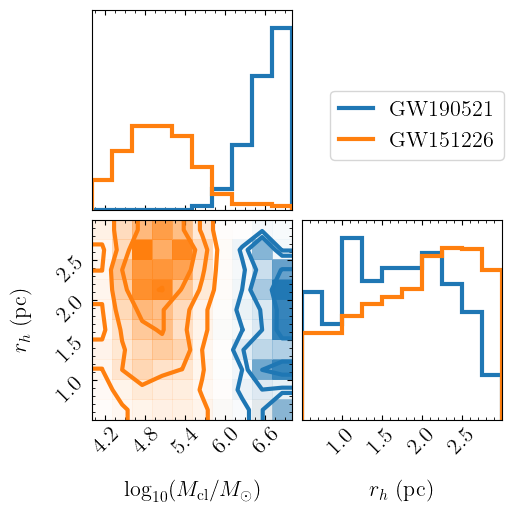

In [13]:
import matplotlib as mpl
#event_names = np.loadtxt("/home/kenkyng/GWTC3-posteriors/event_names_BBH.txt", dtype="str")
event_names = ["GW190521_030229", "GW151226_033853"]
fig_corner = None
for (i, name) in enumerate(event_names):
    try:
        #name = event[16:31]
        cat = h5.File("./Mcl_rh_posterior/"+name+".h5", 'r')
        logMcl_rh_weights = cat["logMcl_rh_weights"][()]
        PEprior_weights = cat["PEprior_weights"][()]
        efficiency_weights = cat["efficiency_weights"][()]
        total_weights = logMcl_rh_weights*PEprior_weights*efficiency_weights
        points = cat["points"][()]
        logMcl_samples, rh_samples = points["logMcl"], points["rh"]
        total_weights /= np.sum(total_weights)
        logMcl_pos_samples = np.random.choice(logMcl_samples, p=total_weights, size = 10000)
        logMcl_pos_lower, logMcl_pos_median, logMcl_pos_upper = HPD_interval(logMcl_pos_samples)
        if not fig_corner:
            fig_corner = corner.corner(np.transpose([logMcl_samples, rh_samples]), bins=10, weights = total_weights, plot_datapoints=False, labels=[log10Mcllabel, rhlabel], color="C0", hist_kwargs={"lw":3})
        #fig_corner.suptitle(name)
        else:
            corner.corner(np.transpose([logMcl_samples, rh_samples]), bins=10, weights = total_weights, plot_datapoints=False, labels=[log10Mcllabel, rhlabel], fig=fig_corner, color="C1", hist_kwargs={"lw":3})
            fig_corner.show()
        cat.close()
    except FileNotFoundError:
        continue
legend_lines = [mpl.lines.Line2D([0],[0],c="C0"), mpl.lines.Line2D([0],[0],c="C1")]
labels = [event_name[:8] for event_name in event_names]
fs = 16
fig_corner.legend(legend_lines, labels, fontsize=fs, bbox_to_anchor=(0, 0, 0.95, 0.8))
for (i, ax) in enumerate(fig_corner.axes):
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    ax.tick_params(direction="in", which="both", top=True, right=True, labelsize=fs)
    map(lambda p: p.set_fontsize(fs), ax.get_xticklabels())
    map(lambda p: p.set_fontsize(fs), ax.get_yticklabels())
fig_corner.savefig("./plots/Mch_rh_corner.pdf")

Some extra testing. Ignored for now.

In [ ]:
data_raw = np.loadtxt("/home/kenkyng/cluster-inference/data/mergers__logMneg1tukey3.7to7.3_rhlinear0.2to4pc.txt", unpack=True)
data_noEje_raw = np.loadtxt("/home/kenkyng/cluster-inference/data/mergers__logMneg1tukey3.7to7.3_rhlinear0.2to4pc__noEjections.txt", unpack=True)
data_prompt_raw = np.loadtxt("/home/kenkyng/cluster-inference/data/mergers__logMneg1tukey3.7to7.3_rhlinear0.2to4pc__promptMerger.txt", unpack=True)

In [ ]:
labels=['channel', 'a','e', 'm1','m2','chi1','chi2','g1','g2',
        'tform','tmerge','zform','zmerge','Nhar','Nsub','q',
        'chieff', 'theta1', 'theta2', 'dphi','mrem', 'chirem', 'gren', 'vgw', 'j1', 'j2', 'Mcl_0', 'zcl_form', 'rh', 'Z']
data_raw = np.core.records.fromarrays(data_raw, names=labels, formats=['f8']*len(labels))
data_noEje_raw = np.core.records.fromarrays(data_noEje_raw, names=labels, formats=['f8']*len(labels))
data_prompt_raw = np.core.records.fromarrays(data_prompt_raw, names=labels, formats=['f8']*len(labels))

In [ ]:
data = data_raw[(data_raw['g1']<4)*(data_raw['zmerge']>0)]
data_noEje = data_noEje_raw[(data_noEje_raw['g1']<4)*(data_noEje_raw['zmerge']>0)]
data_prompt = data_prompt_raw[(data_prompt_raw['g1']<4)*(data_prompt_raw['zmerge']>0)]

In [ ]:
weight = 1./data["Mcl_0"]#*1./(data["rh"]-0.2)
weight_noEje = 1./data_noEje["Mcl_0"]#*1./(data_noEje["rh"]-0.2)
weight_prompt = 1./data_prompt["Mcl_0"]#*1./(data_prompt["rh"]-0.2)
weight[(data["rh"]<0.5)*(data["rh"]>3)*(data["Mcl_0"]<10**4)*(data["Mcl_0"]>10**7)] = 0
weight_noEje[(data_noEje["rh"]<0.5)*(data_noEje["rh"]>3)*(data_noEje["Mcl_0"]<10**4)*(data_noEje["Mcl_0"]>10**7)] = 0
weight_prompt[(data_prompt["rh"]<0.5)*(data_prompt["rh"]>3)*(data_prompt["Mcl_0"]<10**4)*(data_prompt["Mcl_0"]>10**7)] = 0

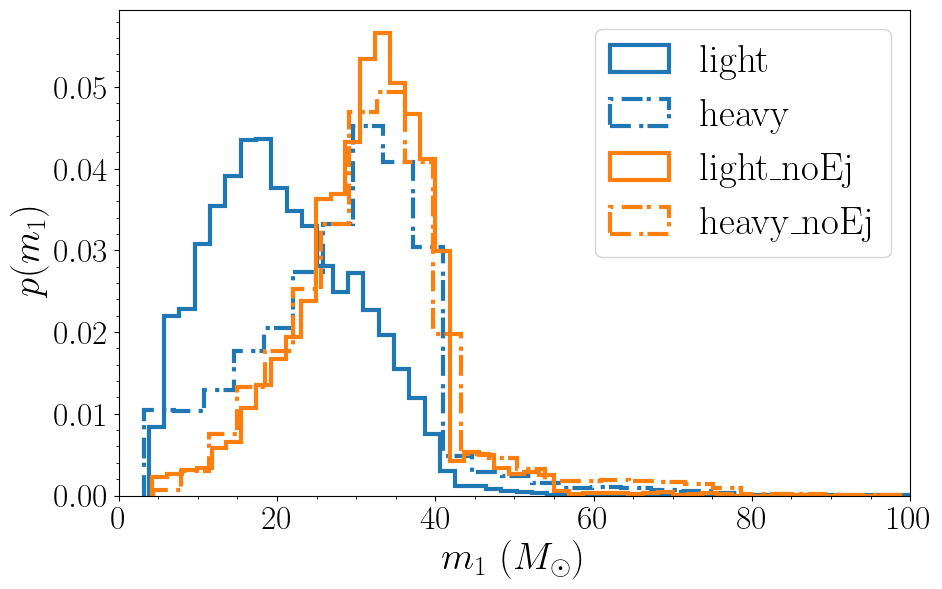

In [ ]:
plt.xlabel(r"$m_1~(M_{\odot})$")
plt.ylabel(r"$p(m_1)$")
plt.hist(data['m1'][data['Mcl_0']<10**5], bins=50, histtype="step", density=True, label=r"light", lw=3, color="C0", weights=weight[data['Mcl_0']<10**5])
plt.hist(data['m1'][data['Mcl_0']>10**5], bins=50, histtype="step", density=True, label=r"heavy", lw=3, color="C0", ls="-.", weights=weight[data['Mcl_0']>10**5])
plt.hist(data_noEje['m1'][data_noEje['Mcl_0']<10**5], bins=50, histtype="step", density=True, label=r"light_noEj", lw=3, color="C1", weights=weight_noEje[data_noEje['Mcl_0']<10**5])
plt.hist(data_noEje['m1'][data_noEje['Mcl_0']>10**5], bins=50, histtype="step", density=True, label=r"heavy_noEj", lw=3, color="C1", ls="-.", weights=weight_noEje[data_noEje['Mcl_0']>10**5])
#plt.hist(data_prompt['m1'][data_prompt['Mcl_0']<10**5], bins=50, histtype="step", density=True, label=r"No delay", lw=3, color="C2", weights=weight_prompt[data_prompt['Mcl_0']<10**5])
#plt.hist(data_prompt['m1'][data_prompt['Mcl_0']>10**5], bins=50, histtype="step", density=True, label=r"No delay", lw=3, color="C2", ls="-.", weights=weight_prompt[data_prompt['Mcl_0']>10**5])
plt.legend()
plt.xlim(0, 100)
plt.savefig("./plots/p_m1_Ej_noEj.pdf")